In [220]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [221]:
import tensorflow as tf
from tensorflow import keras

In [222]:
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers
from keras import applications
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [223]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

In [224]:
sns.set_style("ticks")
sns.set_style('whitegrid')

In [225]:
df = pd.read_csv("data/cleaned_final_data.csv") # OR USE searchData/limitData
df = df.drop_duplicates()
print(df.dtypes)
df.sample(frac=1).head(5)

year                       int64
month                      int64
region                    object
town                      object
block                     object
street_name               object
lease_commence_date        int64
month_remaining_lease      int64
flat_type                 object
flat_model                 int64
floor_area_sqm           float64
storey_range_low           int64
storey_range_high          int64
nearest_mrt               object
min_dist_mrt             float64
nearest_mall              object
min_dist_mall            float64
min_dist_town_in_km      float64
total_population         float64
cpi                      float64
psi                        int64
resale_price             float64
dtype: object


,year,month,region,town,block,street_name,lease_commence_date,month_remaining_lease,flat_type,flat_model,...,storey_range_high,nearest_mrt,min_dist_mrt,nearest_mall,min_dist_mall,min_dist_town_in_km,total_population,cpi,psi,resale_price
59647,2019,10,north,SENGKANG,440B,FERNVALE LINK,2015,1137,5 ROOM,5,...,21,FERNVALE LRT STATION,0.255213,The Seletar Mall,0.301782,11.454970,1.716009,99.930,55,605000.0
65674,2020,1,north,WOODLANDS,149,WOODLANDS STREET 13,1985,770,3 ROOM,12,...,9,MARSILING MRT STATION,0.388052,Marsiling Mall,0.825252,18.119690,1.703850,100.204,33,245000.0
93664,2021,3,north,SEMBAWANG,503A,CANBERRA LINK,2001,953,EXECUTIVE,3,...,9,SEMBAWANG MRT STATION,0.233905,Sun Plaza,0.360387,17.769957,1.544868,101.239,62,580000.0
7604,2017,5,central,TOA PAYOH,121,POTONG PASIR AVENUE 1,1984,792,3 ROOM,8,...,6,POTONG PASIR MRT STATION,0.620874,The Poiz,0.536843,4.951295,1.653498,99.098,62,358000.0
55944,2019,8,north,WOODLANDS,8,MARSILING DRIVE,1976,665,4 ROOM,5,...,6,MARSILING MRT STATION,1.031257,Marsiling Mall,0.917947,18.432782,1.716009,100.209,56,253000.0


In [226]:
cols_to_norm = [
    'month_remaining_lease', 'floor_area_sqm',
    'storey_range_low', 'storey_range_high',
    'min_dist_mrt', 'min_dist_mall', 'min_dist_town_in_km', 'total_population', 'resale_price']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [227]:
# Convert categorical columns to numerical
#df['flat_model'] = df['flat_model'].astype('category').cat.codes
#df['town_num'] = df['town'].astype('category').cat.codes
#df['region_num'] = df['region'].astype('category').cat.codes
df.head(5)


,year,month,region,town,block,street_name,lease_commence_date,month_remaining_lease,flat_type,flat_model,...,storey_range_high,nearest_mrt,min_dist_mrt,nearest_mall,min_dist_mall,min_dist_town_in_km,total_population,cpi,psi,resale_price
0,2017,1,central,ANG MO KIO,406,ANG MO KIO AVENUE 10,1979,0.334855,2 ROOM,5,...,0.1875,BISHAN DEPOT,0.257462,AMK Hub,0.311318,0.385026,0.63474,99.026,29,0.071987
1,2017,1,central,ANG MO KIO,108,ANG MO KIO AVENUE 4,1978,0.321157,3 ROOM,12,...,0.0000,MAYFLOWER MRT STATION,0.046331,Broadway Plaza,0.277670,0.444717,0.63474,99.026,29,0.086072
2,2017,1,central,ANG MO KIO,602,ANG MO KIO AVENUE 5,1980,0.354642,3 ROOM,12,...,0.0000,LENTOR MRT STATION,0.131016,Broadway Plaza,0.474936,0.503145,0.63474,99.026,29,0.095462
3,2017,1,central,ANG MO KIO,465,ANG MO KIO AVENUE 10,1980,0.348554,3 ROOM,12,...,0.0625,ANG MO KIO MRT STATION,0.261477,myVillage At Serangoon Garden,0.277530,0.410110,0.63474,99.026,29,0.097809
4,2017,1,central,ANG MO KIO,601,ANG MO KIO AVENUE 5,1980,0.354642,3 ROOM,12,...,0.0000,LENTOR MRT STATION,0.122820,Broadway Plaza,0.488574,0.505303,0.63474,99.026,29,0.097809


                           year     month  lease_commence_date  \
year                   1.000000 -0.109528             0.124814   
month                 -0.109528  1.000000             0.009307   
lease_commence_date    0.124814  0.009307             1.000000   
month_remaining_lease  0.000132  0.002777             0.991769   
flat_model            -0.012993 -0.008086            -0.119049   
floor_area_sqm        -0.014882  0.004697             0.135443   
storey_range_low       0.019966 -0.003247             0.279048   
storey_range_high      0.019966 -0.003247             0.279048   
min_dist_mrt          -0.007204 -0.001518            -0.157125   
min_dist_mall         -0.002928 -0.006006            -0.250935   
min_dist_town_in_km   -0.004003  0.003347             0.295062   
total_population      -0.269021  0.016775            -0.051496   
cpi                    0.809193  0.020610             0.087124   
psi                   -0.222901 -0.019832            -0.022849   
resale_pri

<AxesSubplot:>

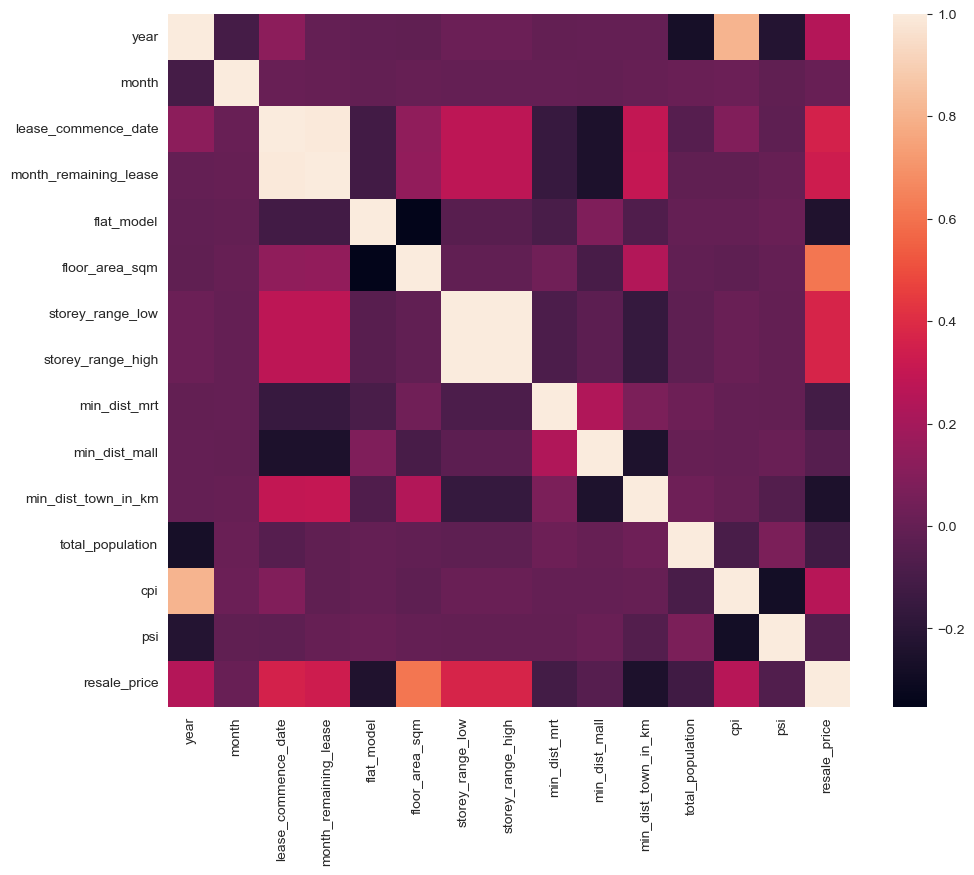

In [228]:
# Compute the correlation matrix
corr = df.corr()
print(corr)

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df.corr())

<AxesSubplot:title={'center':'Town'}>

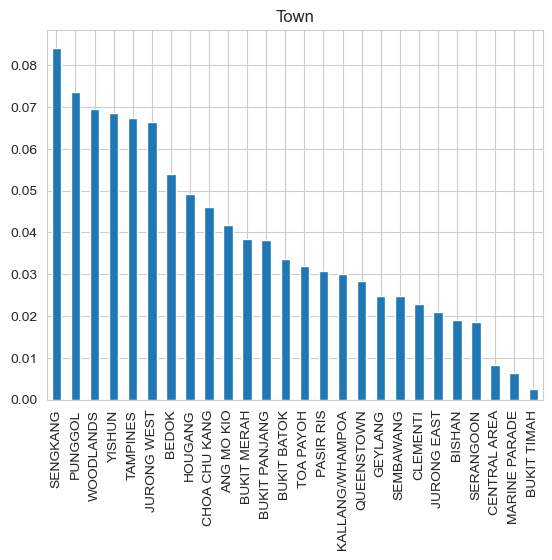

In [229]:
df.town.value_counts(normalize=True).plot(kind='bar', title='Town')

<AxesSubplot:title={'center':'Flat Type'}>

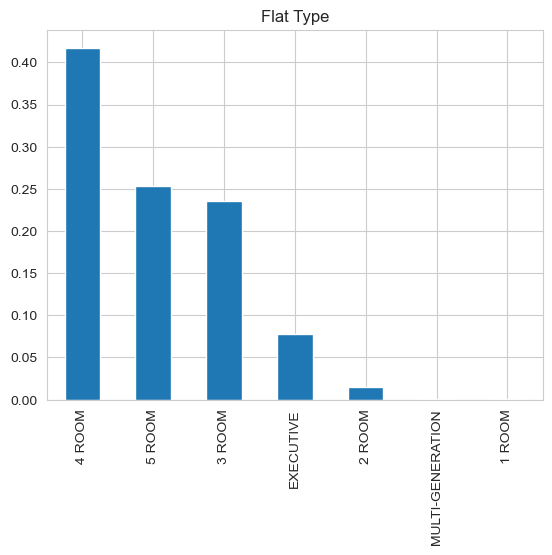

In [230]:
df.flat_type.value_counts(normalize=True).plot(kind='bar', title='Flat Type')

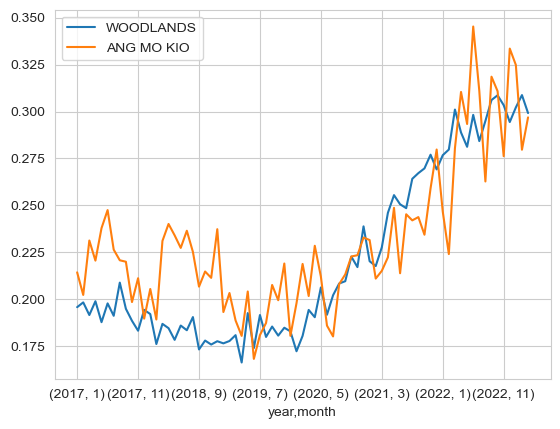

In [231]:
# for each month and year, plot the mean price into line chart with legend
def query_mean_plot_by_town(town):
    df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)
    plt.legend()
    
query_mean_plot_by_town('WOODLANDS')
query_mean_plot_by_town('ANG MO KIO')

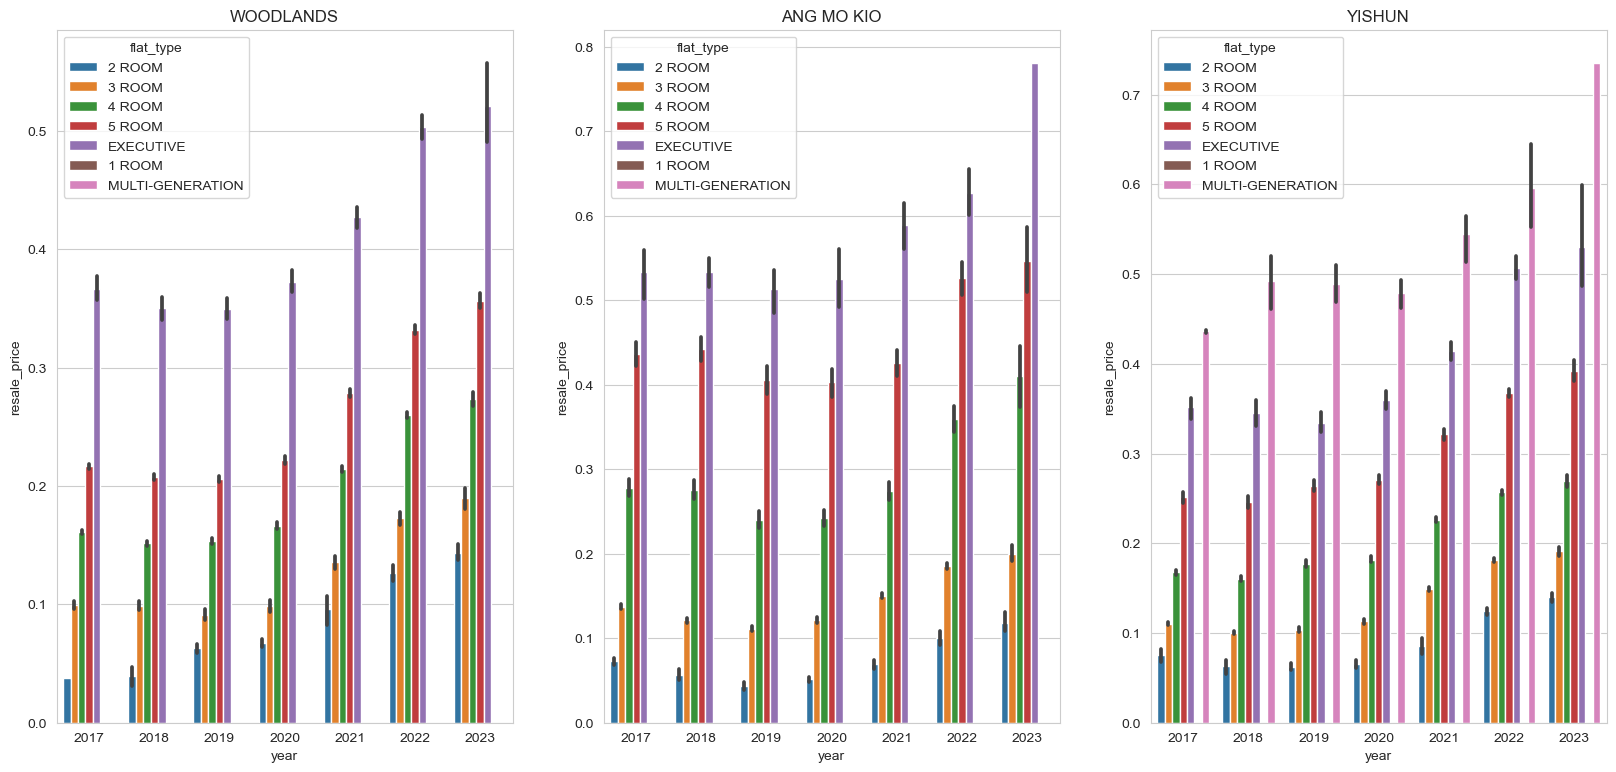

In [232]:
f, ax = plt.subplots(figsize=(20, 9))

def plot_year_against_price(town):
    sns.barplot(data=df[df['town'] == town], x="year", y="resale_price", hue="flat_type", hue_order=df.flat_type.unique())
    plt.title(town)
        
plt.subplot(131)
plot_year_against_price('WOODLANDS')
plt.subplot(132)
plot_year_against_price('ANG MO KIO')
plt.subplot(133)
plot_year_against_price('YISHUN')

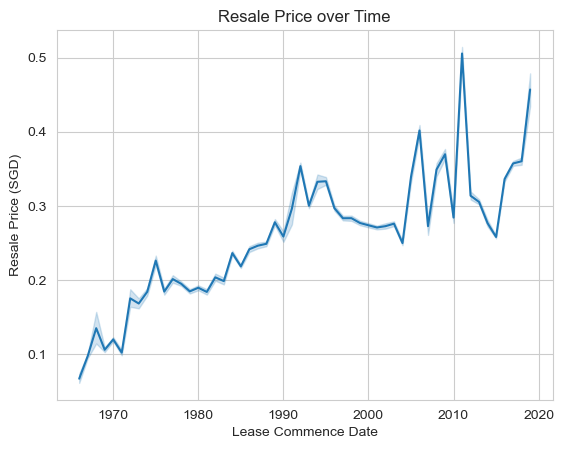

In [233]:
# line plot of lease commence date and resale price
sns.lineplot(x='lease_commence_date', y='resale_price', data=df)
plt.title('Resale Price over Time')
plt.xlabel('Lease Commence Date')
plt.ylabel('Resale Price (SGD)')
plt.show()

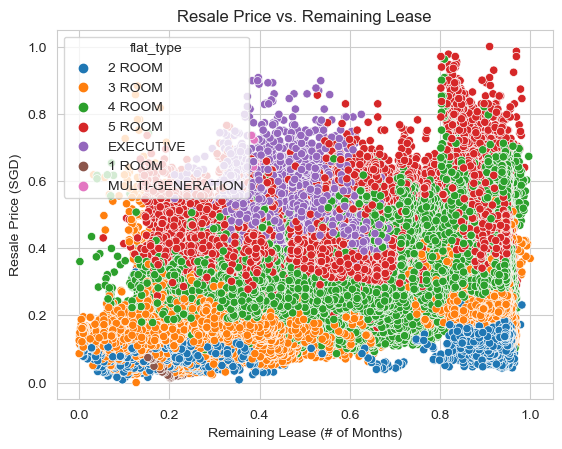

In [234]:
# scatter plot of remaining lease and resale price
sns.scatterplot(x='month_remaining_lease', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price vs. Remaining Lease')
plt.xlabel('Remaining Lease (# of Months)')
plt.ylabel('Resale Price (SGD)')
plt.show()

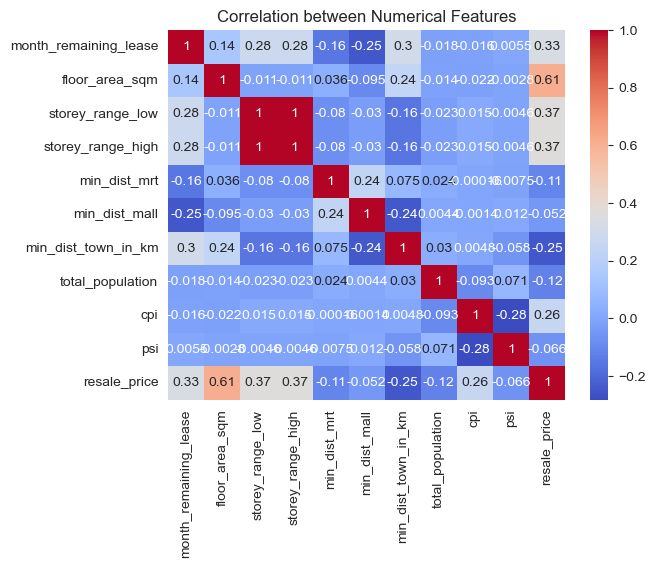

In [235]:
num_col = [
    'month_remaining_lease', 'floor_area_sqm',
    'storey_range_low', 'storey_range_high',
    'min_dist_mrt', 'min_dist_mall', 'min_dist_town_in_km', 'total_population', 'cpi', 'psi', 'resale_price']

corr = df[num_col].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Features')
plt.show()

In [236]:
# Define a custom transformer to apply StandardScaler() to each 2D slice of the 3D array
class SliceScaler(TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_slices, n_features = X.shape
        X_transformed = np.empty_like(X)
        for i in range(n_slices):
            X_transformed[:, i, :] = self.scaler.fit_transform(X[:, i, :])
        return X_transformed
    

In [237]:
class PredictionModel:
    def __init__(self, regressor_type):
        self.isKeras=False
        self.numeric_features = ['month_remaining_lease', 'floor_area_sqm',
            'storey_range_low', 'storey_range_high',
            'min_dist_mrt', 'min_dist_mall', 'min_dist_town_in_km', 'total_population', 'cpi', 'psi']
        self.cat_features = ['flat_model']
        
        self.y_col = 'resale_price'
        self.regressor_type = regressor_type
        
        self.keras_history=None
        
        self.predictor_model =None
        
        if self.regressor_type == "NeuralNetworkRegressor" or self.regressor_type == "ConvolutionalNeuralNetworkRegressor":
            self.isKeras = True;
    
    def train_model_town(self, final_df, town, flat_type):
        target_df = final_df[(final_df['town'] == town) & (final_df['flat_type'] == flat_type)]
        y = target_df[self.y_col]
        X = target_df[self.numeric_features + self.cat_features]
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)        
        return True

    def fit(self):
        if self.regressor_type == "DecisionTreeRegressor":
            classifier = DecisionTreeRegressor(random_state=46)
        elif self.regressor_type == "RandomForestRegressor":
            classifier = RandomForestRegressor(n_estimators=100, random_state=48)
        elif self.regressor_type == "GradientBoostingRegressor":
            classifier = GradientBoostingRegressor()
        elif self.regressor_type == "NeuralNetworkRegressor":
            self.isKeras = True;
        elif self.regressor_type == "ConvolutionalNeuralNetworkRegressor":
            self.isKeras = True;
    
        col_trans = make_column_transformer(
                    (OneHotEncoder(),self.cat_features),
                    remainder = "passthrough"
            )
        
        if(self.isKeras==False):
            regressor = make_pipeline(col_trans, classifier)
            return regressor.fit(self.X_train, self.y_train)
        else:
            # If Keras is True
            if self.regressor_type == "NeuralNetworkRegressor":
                
                regressor = KerasRegressor(build_fn=self.build_neural_network_model, verbose=1)
                pipeline = make_pipeline(col_trans, StandardScaler(), regressor)
                
                # Print the summary
                print('Neural Network Model summary:')
                for i, step in enumerate(pipeline.steps):
                    print('Step {}: {}'.format(i, step[0]))
                    print('  - Estimator: {}'.format(step[1]))
                    for key, value in step[1].__dict__.items():
                        if '__' not in key:
                            print('  - {}: {}'.format(key, value))
                
                # Fit the pipeline to the training data
                self.predictor_model = pipeline.fit(self.X_train, self.y_train, kerasregressor__epochs=150, kerasregressor__validation_split=0.2, kerasregressor__verbose=2)
                
                self.keras_history = pipeline.named_steps['kerasregressor'].model.history
                
                # Print the summary of the Keras model
                pipeline.named_steps['kerasregressor'].model.summary()
                
                return self.predictor_model
            
            elif self.regressor_type == "ConvolutionalNeuralNetworkRegressor":
                
                # reshape to add timesteps for Convolutional 1D
                sample_size = self.X_train.shape[0] # number of samples in train set
                time_steps  = self.X_train.shape[1] # number of features in train set
                input_dimension = 1               # each feature is represented by 1 number
                
                # convert dataframe into numpy.ndarray
                X_train_array = self.X_train.values
                X_test_array  = self.X_test.values

                self.X_train = X_train_array.reshape(sample_size,time_steps,input_dimension)
                self.X_test  = X_test_array.reshape(self.X_test.shape[0],self.X_test.shape[1],1)
                
                regressor = KerasRegressor(build_fn=self.build_convolutional_neural_network_model, verbose=1)
                pipeline = make_pipeline(SliceScaler(), regressor)
                #todo: find a way to include the categorical values into the 3d pipeline
                
                # Print the summary
                print('Convolutional Neural Network Model summary:')
                for i, step in enumerate(pipeline.steps):
                    print('Step {}: {}'.format(i, step[0]))
                    print('  - Estimator: {}'.format(step[1]))
                    for key, value in step[1].__dict__.items():
                        if '__' not in key:
                            print('  - {}: {}'.format(key, value))
                
                # Fit the pipeline to the training data
                self.predictor_model = pipeline.fit(self.X_train, self.y_train, kerasregressor__epochs=150, kerasregressor__validation_split=0.2, kerasregressor__verbose=2)
                
                self.keras_history = pipeline.named_steps['kerasregressor'].model.history
                # Print the summary of the Keras model
                pipeline.named_steps['kerasregressor'].model.summary()
                
                return self.predictor_model
            
    def build_neural_network_model(self):
        #Experiment with deeper and wider networks
        model = Sequential()
        
         # update size of input_size including the additional columns hotencoded in the preprocessor
        input_size = int(self.X_train.shape[1])
        for cat_feature in self.cat_features:
            input_size += int(df[cat_feature].nunique().bit_length())
            
        model.add(Dense(128, input_dim=input_size, activation='relu' ))
        model.add(Dense(64, activation='relu'))

        #Output layer
        model.add(Dense(1, activation='linear'))

        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        return model
        
    def build_convolutional_neural_network_model(self):
        n_timesteps = self.X_train.shape[1]
        n_features  = self.X_train.shape[2] 
        
#         # update size of input_size including the additional columns hotencoded in the preprocessor
#         for cat_feature in self.cat_features:
#             n_features += int(df[cat_feature].nunique().bit_length())
            
        model = keras.Sequential(name="model_conv1D")
        model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
        model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
        model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
        model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
        model.add(keras.layers.Dense(n_features, name="Dense_2"))
        optimizer = tf.keras.optimizers.RMSprop(0.001)
        model.compile(loss='mse',optimizer=optimizer,metrics=['mae'])
        return model
    
    def predict(self, regressor):
        return regressor.predict(self.X_test)

    def evaluate(self, y_pred):
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mae_value = mean_absolute_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)
        
        plt.figure(figsize=(7,4))
        plt.scatter(self.y_test, y_pred, c='crimson')
        plt.yscale('log')
        plt.xscale('log')

        p1 = max(max(y_pred), max(self.y_test))
        p2 = min(min(y_pred), min(self.y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        plt.axis('equal')
        plt.show()
        
        print("Root Mean Squared Error: {:.4f}".format(rmse))
        print("Mean absolute error: {:.4f}".format(mae_value) )
        print("R2 score: {:.4f}".format(r2))
        
        # only for neural networks: plot the training and validation accuracy and loss at each epoch
        if(self.isKeras==True):
            loss = self.keras_history.history['loss']
            val_loss = self.keras_history.history['val_loss']
            
            epochs = range(1, len(loss) + 1)
            plt.plot(epochs, loss, 'y', label='Training loss')
            plt.plot(epochs, val_loss, 'r', label='Validation loss')
            plt.title('Training and validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            acc = self.keras_history.history['mae']
            val_acc = self.keras_history.history['val_mae']
            plt.plot(epochs, acc, 'y', label='Training MAE')
            plt.plot(epochs, val_acc, 'r', label='Validation MAE')
            plt.title('Training and validation MAE')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
            
            predictions = self.predictor_model.predict(self.X_test[:5])
            print("Predicted values are: ", predictions)
            print("Real values are: ", self.y_test[:5])

    
    def plot_importance(self, regressor):
        fig, ax = plt.subplots(figsize=(7, 4))
        importances = pd.Series(data=regressor.feature_importances_, index=self.X_train.columns)
        importances_sorted = importances.sort_values()
        importances_sorted.plot(kind='barh', color='lightgreen')
        plt.title('Features Importances')
        plt.show()
    
    
    def plot_permutation(self, regressor):
        fig, ax = plt.subplots(figsize=(7, 4))
        result = permutation_importance(regressor, self.X_test, self.y_test, n_repeats=10, random_state=42, n_jobs=2)
        sorted_idx = result.importances_mean.argsort()
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(self.features)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        plt.show()

In [238]:
town = 'WOODLANDS'
flat_type = '4 ROOM'

fig = plt.figure(figsize=(6, 6))
df = df.dropna()

<Figure size 600x600 with 0 Axes>

WOODLANDS - 4 ROOM


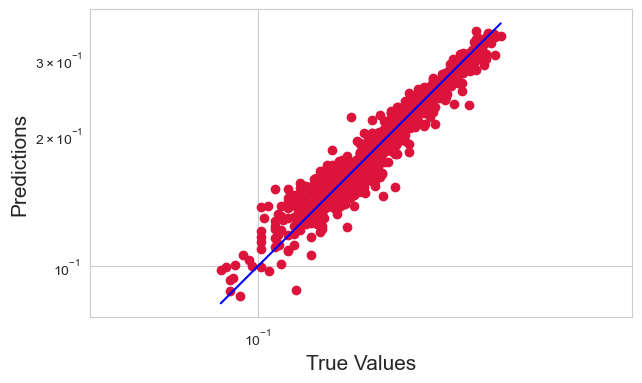

Root Mean Squared Error: 0.0135
Mean absolute error: 0.0102
R2 score: 0.9447


In [239]:
# Random Forest Regressor
print(town, "-", flat_type)
random_forest_model = PredictionModel('RandomForestRegressor')
random_forest_model.train_model_town(df.copy(), town, flat_type)
random_forest_regressor = random_forest_model.fit()
y_pred = random_forest_model.predict(random_forest_regressor)
random_forest_model.evaluate(y_pred)

WOODLANDS - 4 ROOM


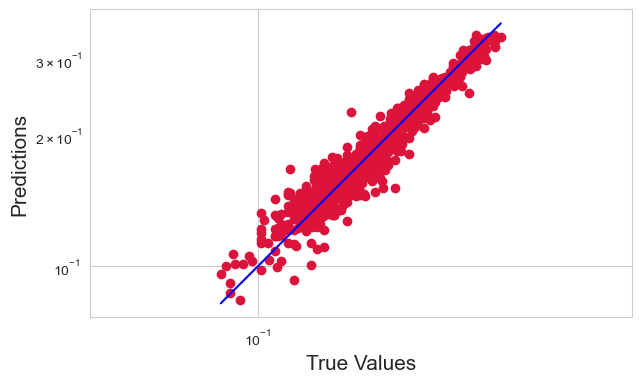

Root Mean Squared Error: 0.0132
Mean absolute error: 0.0102
R2 score: 0.9468


In [240]:
# Gradient Boosting Regressor
print(town, "-", flat_type)
random_forest_model = PredictionModel('GradientBoostingRegressor')
random_forest_model.train_model_town(df.copy(), town, flat_type)
random_forest_regressor = random_forest_model.fit()
y_pred = random_forest_model.predict(random_forest_regressor)
random_forest_model.evaluate(y_pred)

In [241]:
# #todo: convert to binary encoding OR mean encoding (w/ cross-validation)
# print("region_count: "+str(df.region.unique().size))
# # 3 binary

# print("town_count: ",df.town.unique().size)
# # 5 binary

# print("flat_type_count: ",df.flat_type.unique().size)
# # 3 binary

WOODLANDS - 4 ROOM
Neural Network Model summary:
Step 0: columntransformer
  - Estimator: ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['flat_model'])])
  - transformers: [('onehotencoder', OneHotEncoder(), ['flat_model'])]
  - remainder: passthrough
  - sparse_threshold: 0.3
  - n_jobs: None
  - transformer_weights: None
  - verbose: False
  - verbose_feature_names_out: True
Step 1: standardscaler
  - Estimator: StandardScaler()
  - with_mean: True
  - with_std: True
  - copy: True
Step 2: kerasregressor
  - Estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x15f866680>
  - build_fn: <bound method PredictionModel.build_neural_network_model of <__main__.PredictionModel object at 0x15f7b31c0>>
  - sk_params: {'verbose': 1}
Epoch 1/150


/var/folders/yw/j_0fbvld765_5vqn9j4tst540000gn/T/ipykernel_15931/1841217978.py:51: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=self.build_neural_network_model, verbose=1)


92/92 - 0s - loss: 0.0112 - mae: 0.0721 - val_loss: 0.0024 - val_mae: 0.0390 - 492ms/epoch - 5ms/step
Epoch 2/150
92/92 - 0s - loss: 0.0017 - mae: 0.0321 - val_loss: 0.0016 - val_mae: 0.0318 - 104ms/epoch - 1ms/step
Epoch 3/150
92/92 - 0s - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0285 - 105ms/epoch - 1ms/step
Epoch 4/150
92/92 - 0s - loss: 9.5350e-04 - mae: 0.0241 - val_loss: 0.0012 - val_mae: 0.0272 - 109ms/epoch - 1ms/step
Epoch 5/150
92/92 - 0s - loss: 0.0015 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0261 - 111ms/epoch - 1ms/step
Epoch 6/150
92/92 - 0s - loss: 9.0026e-04 - mae: 0.0227 - val_loss: 9.1179e-04 - val_mae: 0.0234 - 102ms/epoch - 1ms/step
Epoch 7/150
92/92 - 0s - loss: 6.6364e-04 - mae: 0.0196 - val_loss: 8.0333e-04 - val_mae: 0.0223 - 101ms/epoch - 1ms/step
Epoch 8/150
92/92 - 0s - loss: 6.8191e-04 - mae: 0.0198 - val_loss: 8.7984e-04 - val_mae: 0.0221 - 99ms/epoch - 1ms/step
Epoch 9/150
92/92 - 0s - loss: 7.5206e-04 - mae: 0.0187 - val_loss: 9.145

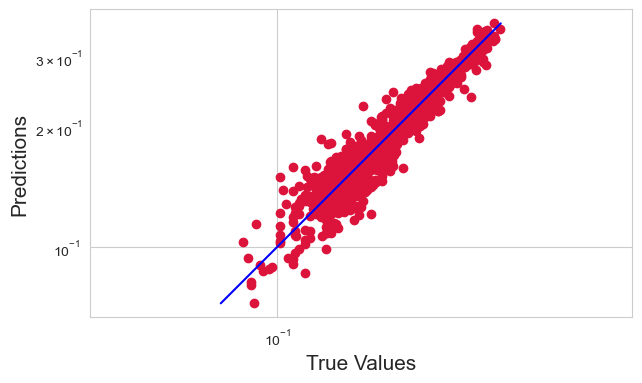

Root Mean Squared Error: 0.0158
Mean absolute error: 0.0123
R2 score: 0.9241


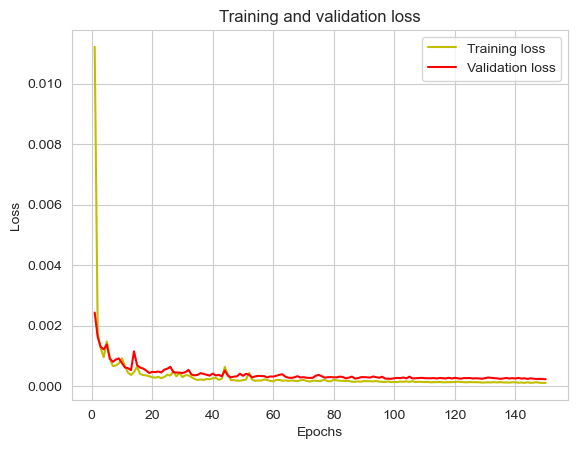

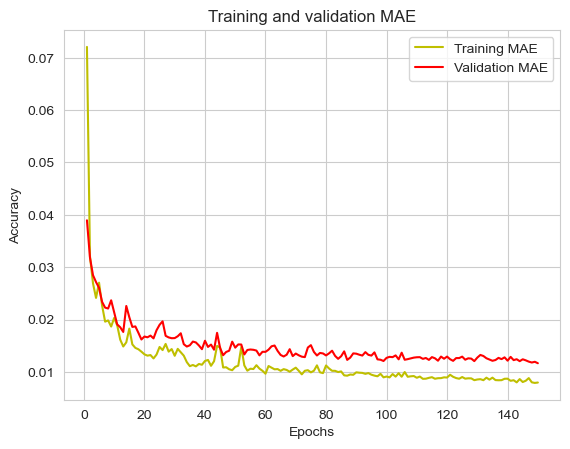

1/1 [==============================] - 0s 20ms/step
Predicted values are:  [0.14284964 0.23474304 0.10392118 0.1671609  0.16480556]
Real values are:  40216    0.126761
89694    0.246479
52007    0.117371
14850    0.168232
26113    0.136933
Name: resale_price, dtype: float64


In [242]:
print(town, "-", flat_type)
neural_network_model = PredictionModel('NeuralNetworkRegressor')
neural_network_model.train_model_town(df.copy(), town, flat_type)
neural_network_regressor = neural_network_model.fit()
y_pred = neural_network_model.predict(neural_network_regressor)
neural_network_model.evaluate(y_pred)

WOODLANDS - 4 ROOM
Convolutional Neural Network Model summary:
Step 0: slicescaler
  - Estimator: <__main__.SliceScaler object at 0x15f7d6920>
  - scaler: StandardScaler()
Step 1: kerasregressor
  - Estimator: <keras.wrappers.scikit_learn.KerasRegressor object at 0x15f1ab8e0>
  - build_fn: <bound method PredictionModel.build_convolutional_neural_network_model of <__main__.PredictionModel object at 0x15f7b2020>>
  - sk_params: {'verbose': 1}
Epoch 1/150


/var/folders/yw/j_0fbvld765_5vqn9j4tst540000gn/T/ipykernel_15931/1841217978.py:87: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=self.build_convolutional_neural_network_model, verbose=1)


92/92 - 1s - loss: 0.0038 - mae: 0.0445 - val_loss: 0.0011 - val_mae: 0.0261 - 839ms/epoch - 9ms/step
Epoch 2/150
92/92 - 0s - loss: 0.0014 - mae: 0.0295 - val_loss: 6.6344e-04 - val_mae: 0.0206 - 138ms/epoch - 1ms/step
Epoch 3/150
92/92 - 0s - loss: 0.0011 - mae: 0.0255 - val_loss: 5.8997e-04 - val_mae: 0.0196 - 138ms/epoch - 1ms/step
Epoch 4/150
92/92 - 0s - loss: 8.5309e-04 - mae: 0.0229 - val_loss: 4.9695e-04 - val_mae: 0.0178 - 139ms/epoch - 2ms/step
Epoch 5/150
92/92 - 0s - loss: 8.1460e-04 - mae: 0.0223 - val_loss: 4.5742e-04 - val_mae: 0.0171 - 137ms/epoch - 1ms/step
Epoch 6/150
92/92 - 0s - loss: 7.1075e-04 - mae: 0.0209 - val_loss: 5.9862e-04 - val_mae: 0.0194 - 138ms/epoch - 2ms/step
Epoch 7/150
92/92 - 0s - loss: 7.0113e-04 - mae: 0.0206 - val_loss: 3.8913e-04 - val_mae: 0.0156 - 138ms/epoch - 1ms/step
Epoch 8/150
92/92 - 0s - loss: 6.2669e-04 - mae: 0.0196 - val_loss: 3.8168e-04 - val_mae: 0.0156 - 138ms/epoch - 2ms/step
Epoch 9/150
92/92 - 0s - loss: 6.0393e-04 - mae: 0.0

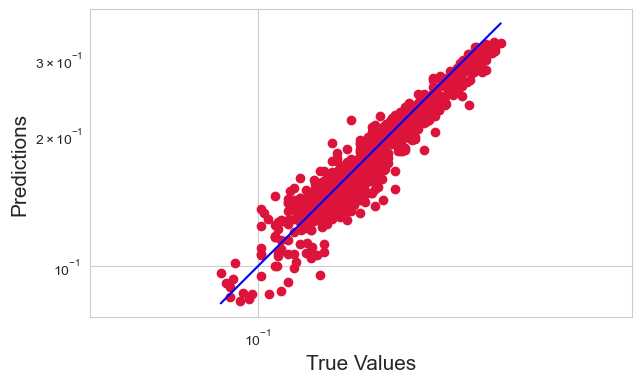

Root Mean Squared Error: 0.0163
Mean absolute error: 0.0126
R2 score: 0.9197


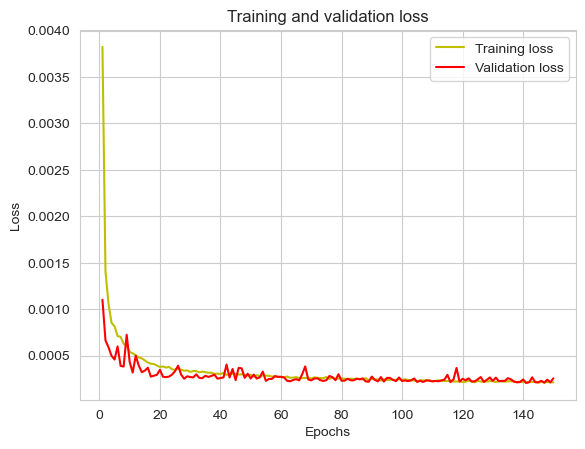

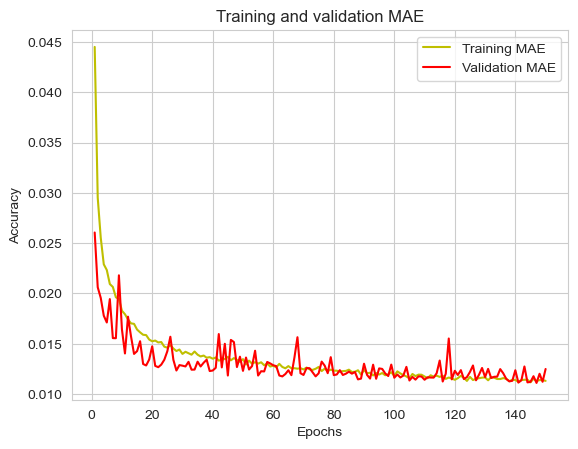

1/1 [==============================] - 0s 20ms/step
Predicted values are:  [0.1341269  0.27357584 0.1836828  0.19775648 0.14814013]
Real values are:  40216    0.126761
89694    0.246479
52007    0.117371
14850    0.168232
26113    0.136933
Name: resale_price, dtype: float64


In [243]:
print(town, "-", flat_type)
convolutional_neural_network_model = PredictionModel('ConvolutionalNeuralNetworkRegressor')
convolutional_neural_network_model.train_model_town(df.copy(), town, flat_type)
convolutional_neural_network_regressor = convolutional_neural_network_model.fit()
y_pred = convolutional_neural_network_model.predict(convolutional_neural_network_regressor)
convolutional_neural_network_model.evaluate(y_pred)

In [244]:
town = 'BISHAN'
flat_type = '4 ROOM'

# Get the data
df_lstm = df.copy()

# Filter the data to only include the selected town and flat type
df_lstm = df_lstm[(df_lstm['town'] == town) & (df_lstm['flat_type'] == flat_type)]

# Select the relevant columns
df_lstm = df[['resale_price', 'year', 'month', 'floor_area_sqm', 'month_remaining_lease', 'storey_range_high', 'min_dist_town_in_km', 'cpi']]

# Convert year and month columns to datetime format
df_lstm['date'] = pd.to_datetime(df_lstm['year'].astype(str) + '-' + df_lstm['month'].astype(str), format='%Y-%m')

# Set the date column as the index
df_lstm.set_index('date', inplace=True)

# Resample the data to monthly frequency and fill missing values
df_lstm = df_lstm.resample('M').mean().fillna(method='ffill')

/var/folders/yw/j_0fbvld765_5vqn9j4tst540000gn/T/ipykernel_15931/2821591016.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm['date'] = pd.to_datetime(df_lstm['year'].astype(str) + '-' + df_lstm['month'].astype(str), format='%Y-%m')


In [245]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df_lstm = pd.DataFrame(scaler.fit_transform(df_lstm), columns=df_lstm.columns, index=df_lstm.index)

# Split the data into training and testing sets
train_size = int(len(df_lstm) * 0.8)
train_data, test_data = df_lstm.iloc[:train_size], df_lstm.iloc[train_size:]

# Define a function to create sequences of past observations and their target values
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data.iloc[i:(i+seq_length)].values)
        y.append(data.iloc[i+seq_length]['resale_price'])
    return np.array(X), np.array(y)

# Create sequences of past observations and their target values for training and testing sets
seq_length = 6
X_train, y_train = create_sequences(train_data, seq_length)

X_test, y_test = create_sequences(test_data, seq_length)

# Define and compile the LSTM model

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 8)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

3/3 [==============================] - 0s 2ms/step


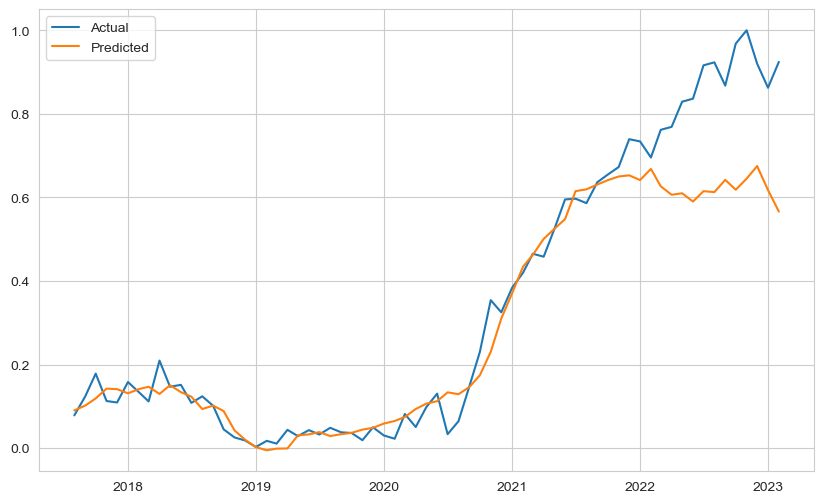

Mean Squared Error: 0.09186092298031484
Root Mean Squared Error: 0.30308566937470804
Mean Absolute Error: 0.2988071379450777
Coefficient of Determination (R^2): -48.78685108389429


In [246]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, verbose=0)

# Make predictions using the testing data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate the coefficient of determination (R^2)
r2 = r2_score(y_test, y_pred)

# Make predictions using the entire dataset
X_all, y_all = create_sequences(df_lstm, seq_length)
y_pred = model.predict(X_all)

# Plot the predicted values with the actual values for the testing set
plt.figure(figsize=(10, 6))
plt.plot(df_lstm.index[seq_length:-1], y_all, label='Actual')
plt.plot(df_lstm.index[seq_length:-1], y_pred, label='Predicted')
plt.legend()
plt.show()
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('Coefficient of Determination (R^2):', r2)